# Set up Detectron2

In [6]:
#!pip install opencv-python
#!pip install opencv-contrib-python-headless
#!pip install gcc

You should consider upgrading via the 'C:\Users\vlad1\anaconda3\envs\d2\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\vlad1\anaconda3\envs\d2\python.exe -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement gcc (from versions: none)
ERROR: No matching distribution found for gcc
You should consider upgrading via the 'C:\Users\vlad1\anaconda3\envs\d2\python.exe -m pip install --upgrade pip' command.


In [1]:
import sys, os, distutils.core

In [2]:
#dist = distutils.core.run_setup("./setup.py")
#!pip install {' '.join([f"'{x}'" for x in dist.install_requires])}

In [3]:
import torch, detectron2
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

torch:  1.13 ; cuda:  1.13.1
detectron2: 0.6


In [4]:
import torch
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

Using device: cuda
NVIDIA GeForce RTX 2060


In [6]:
#Set location where packages are installedc:\users\vlad1\anaconda3\envs\alphapose\lib\site-packages
#sys.path.append('C:/users/vlad1/anaconda3/envs/d2/lib/site-packages')

In [7]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

# import some common libraries
import numpy as np
import time
import tqdm
import os, json, random
import cv2

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.utils.visualizer import ColorMode, Visualizer

# Fine-Tunning

In [8]:
#from detectron2.data.datasets import register_coco_instances

#register_coco_instances("my_dataset_coco_person_640", {}, "../coco_2017_person_640/labels.json", "../coco_2017_person_640/data")

Train

In [9]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file('configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml')
#cfg.DATASETS.TRAIN = ("my_dataset_coco_person_640", )
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = 'detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl'  
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  
cfg.SOLVER.MAX_ITER = 350    
cfg.SOLVER.STEPS = []       
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  

#Uncoment if you want to fine-tune the model on the selected cfg.DATASETS.TRAIN data
#os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
#trainer = DefaultTrainer(cfg) 
#trainer.resume_or_load(resume=False)
#trainer.train()

In [10]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the fine-tunned model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
predictor = DefaultPredictor(cfg)

In [11]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageChops
import math
import copy

img_list = []
#C:\Users\vlad1\Documents\Cenas\uu\Thesis\3DReconstruction\Detectron2\data/B64396_00.15.40_00.16.10/B64396_0
for png in os.listdir("./data/AAAA"):
    if png.endswith('.png'):
        img = cv2.imread(os.path.join("./data/AAAA", png))
        img_list.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        #img_list.append(img)

In [12]:
def lab_normalization_(frames):
    #Solution gotten from:
    #https://github.com/jrosebr1/color_transfer
    assert len(frames) > 1, f'Cannot normalize frames, if only one is given'

    lab_reference = cv2.cvtColor(frames[0], cv2.COLOR_BGR2LAB)
    l_ref, a_ref, b_ref = cv2.split(lab_reference)

    mean_l_ref, std_l_ref = cv2.meanStdDev(l_ref)
    mean_a_ref, std_a_ref = cv2.meanStdDev(a_ref)
    mean_b_ref, std_b_ref = cv2.meanStdDev(b_ref)

    normalized_frames = [frames[0]]

    for frame in frames[1:]:
        lab_current = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
        l_cur, a_cur, b_cur = cv2.split(lab_current)

        mean_l_cur, std_l_cur = cv2.meanStdDev(l_cur)
        mean_a_cur, std_a_cur = cv2.meanStdDev(a_cur)
        mean_b_cur, std_b_cur = cv2.meanStdDev(b_cur)

        #l_cur = np.uint8(np.clip(l_cur - mean_l_cur + mean_l_ref, 0, 255))
        #a_cur = np.uint8(np.clip(a_cur - mean_a_cur + mean_a_ref, 0, 255))
        #b_cur = np.uint8(np.clip(b_cur - mean_b_cur + mean_b_ref, 0, 255))
        
        # Normalize the LAB channels of the target frame using the statistics of the source frame
        l_cur = np.uint8(np.clip((l_cur - mean_l_cur) * (std_l_ref / std_l_cur) + mean_l_ref, 0, 255))
        a_cur = np.uint8(np.clip((a_cur - mean_a_cur) * (std_a_ref / std_a_cur) + mean_a_ref, 0, 255))
        b_cur = np.uint8(np.clip((b_cur - mean_b_cur) * (std_b_ref / std_b_cur) + mean_b_ref, 0, 255))

     
        lab_transfer = cv2.merge((l_cur, a_cur, b_cur))
        frame_transfer = cv2.cvtColor(lab_transfer, cv2.COLOR_LAB2BGR)
        normalized_frames.append(frame_transfer)

    return normalized_frames


In [13]:
def color_transfer(frames):
    if len(frames) < 2:
        raise ValueError("At least two frames are required for color transfer.")

    # Convert the first frame to the LAB color space
    lab_reference = cv2.cvtColor(frames[0], cv2.COLOR_BGR2LAB)
    l_ref, a_ref, b_ref = cv2.split(lab_reference)

    # Compute the mean and standard deviation of the LAB channels
    mean_l_ref, std_l_ref = cv2.meanStdDev(l_ref)
    mean_a_ref, std_a_ref = cv2.meanStdDev(a_ref)
    mean_b_ref, std_b_ref = cv2.meanStdDev(b_ref)

    normalized_frames = [frames[0]]

    for frame in frames[1:]:
        # Convert the current frame to the LAB color space
        lab_current = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
        l_cur, a_cur, b_cur = cv2.split(lab_current)

        # Compute the mean and standard deviation of the LAB channels
        mean_l_cur, std_l_cur = cv2.meanStdDev(l_cur)
        mean_a_cur, std_a_cur = cv2.meanStdDev(a_cur)
        mean_b_cur, std_b_cur = cv2.meanStdDev(b_cur)

        # Subtract the mean of each channel and convert back to 'uint8'
        l_cur = np.uint8(np.clip(l_cur - mean_l_cur + mean_l_ref, 0, 255))
        a_cur = np.uint8(np.clip(a_cur - mean_a_cur + mean_a_ref, 0, 255))
        b_cur = np.uint8(np.clip(b_cur - mean_b_cur + mean_b_ref, 0, 255))

        # Merge the transformed channels
        lab_transfer = cv2.merge((l_cur, a_cur, b_cur))

        # Convert the transformed LAB image back to BGR color space
        frame_transfer = cv2.cvtColor(lab_transfer, cv2.COLOR_LAB2BGR)
        normalized_frames.append(frame_transfer)

    return normalized_frames


In [14]:

#for img in img_list:
detection_view_list = []
visualization_view_list = []

for img in img_list:
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
    visualization = v.draw_instance_predictions(outputs["instances"].to('cpu'))
    visualization = cv2.cvtColor(visualization.get_image(), cv2.COLOR_RGB2BGR)
    detection_view_list.append(outputs)
    visualization_view_list.append(visualization)
#plt.imshow(visualization)



c:\Users\vlad1\anaconda3\envs\d2\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [15]:
norm_vae_frames = lab_normalization_(img_list)

AssertionError: Cannot normalize frames, if only one is given

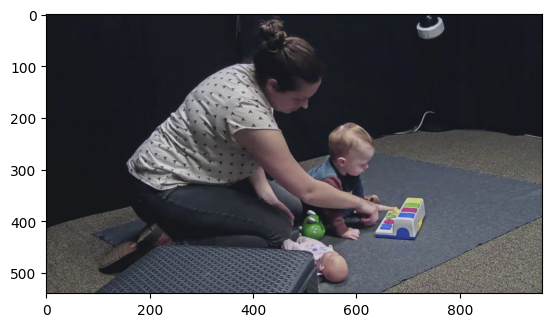

In [109]:
plt.imshow(norm_vae_frames[2])

In [56]:
detection_view_list[-1]['instances'].pred_boxes.tensor.cpu()

tensor([[ 87.9157,  99.5961, 355.2946, 521.7148],
        [241.3651, 314.6250, 497.6748, 538.1198]])

In [46]:
det_boxes = copy.deepcopy(detection_view_list[0]['instances'].pred_boxes.tensor.cpu())
alpha_boxes = [[251.68767037130092, 225.8168664690068, 241.85493910062243, 237.8149408886162], [499.82989113030874, 65.40857951603712, 280.0055231665842, 408.0875669733492]]

In [16]:
def calc_point_overlap(key_a, key_b):
    #If value close to 0, then keypoints belong to the same person
    assert len(key_a) == len(key_b)
    mean = 0
    for k_a, k_b in zip(key_a, key_b):
        mean += abs(k_a - k_b)
    return mean/len(key_a)


def calc_box_overlap(box_detectron, box_list_alphapose):
    '''
    NOTE
    box_detectron: box values are exact pixel coordinates
    box_alphapose: down right corner (idx 2 & 3) are the exact pixel value minus the top left values (idx 0 & 1)
    '''

    #Set box_detectron values to the same format as box_list_alphapose
    box_detectron[2] = abs(box_detectron[2] - box_detectron[0])
    box_detectron[3] = abs(box_detectron[3] - box_detectron[1])

    overlap_a = calc_point_overlap(box_detectron, box_list_alphapose[0])
    overlap_b = calc_point_overlap(box_detectron, box_list_alphapose[1])

    idx = 0 if overlap_a < overlap_b else 1
    best_overlap = overlap_a if overlap_a < overlap_b else overlap_b

    return idx, best_overlap

In [17]:
sys.maxsize

9223372036854775807

In [18]:
#detectron_alpha_map = [-1, -1]

detectron_alpha_map = {
  0: sys.maxsize,
  1: sys.maxsize
}

detectron_alpha_map_idx = [None, None]

for curr_idx, det_b in enumerate(det_boxes):
    best_idx, best_overlap = calc_box_overlap(det_b, alpha_boxes)
    print(best_idx, best_overlap)
    if detectron_alpha_map[best_idx] > best_overlap:
        detectron_alpha_map[best_idx] = best_overlap
        detectron_alpha_map_idx[best_idx] = curr_idx

0 tensor(153.5308)
0 tensor(20.3447)
1 tensor(32.7575)
1 tensor(71.3042)


In [19]:
print(detectron_alpha_map)
print(detectron_alpha_map_idx)

{0: tensor(20.3447), 1: tensor(32.7575)}
[1, 2]


In [47]:
def calc_point_overlap(key_a, key_b):
    #If value close to 0, then keypoints belong to the same person
    assert len(key_a) == len(key_b)
    mean = 0
    for k_a, k_b in zip(key_a, key_b):
        mean += abs(k_a - k_b)
    return mean/len(key_a)

In [48]:
def calc_box_overlap(box_detectron, box_list_alphapose):
    '''
    NOTE
    box_detectron: box values are exact pixel coordinates
    box_alphapose: down right corner (idx 2 & 3) are the exact pixel value minus the top left values (idx 0 & 1)
    '''

    #Set box_detectron values to the same format as box_list_alphapose
    box_detectron[2] = abs(box_detectron[2] - box_detectron[0])
    box_detectron[3] = abs(box_detectron[3] - box_detectron[1])

    overlap_a = calc_point_overlap(box_detectron, box_list_alphapose[0])
    overlap_b = calc_point_overlap(box_detectron, box_list_alphapose[1])

    return 0 if overlap_a < overlap_b else 1




In [22]:
print(calc_box_overlap([500.5347,  235.82939, 698.21826, 484.5784], [[512.4229736328125, 249.22869873046875, 213.8851318359375, 239.52853393554688], [225.45570373535156, 198.48431396484375, 344.594970703125, 281.2178039550781]]))
print()
print(calc_box_overlap([312.37036, 199.55234, 567.19574, 457.23495], [[512.4229736328125, 249.22869873046875, 213.8851318359375, 239.52853393554688], [225.45570373535156, 198.48431396484375, 344.594970703125, 281.2178039550781]]))

0

1


In [16]:
import copy

def get_det_masks(out_inst, in_img):
    #assert len(out_inst['instances']) >= 2, f'Frame contains less than 2 detections!'

    colored_mask_list = [] * 2

    for i in range(2):  #if there are more detections, we get the 2 with highest score
        mask = out_inst['instances'].pred_masks.cpu().numpy()[i]
        box = out_inst['instances'].pred_boxes.tensor.cpu().numpy()[i]

        mask_h = int(math.ceil(box[3]-box[1]))
        mask_w = int(math.ceil(box[2]-box[0]))

        temp_mask = np.zeros((mask_h, mask_w))
        for h_id in range(int(box[1]), int(box[3])):
            for w_id in range(int(box[0]), int(box[2])):
                temp_mask[h_id - int(box[1])][w_id - int(box[0])] = mask[h_id][w_id]

        temp_mask_fill = np.zeros((mask_h, mask_w, 3))
        
        for h_id, h_bw in enumerate(temp_mask):
            for w_id, w_bw in enumerate(h_bw):
                if w_bw == 0:
                    temp_mask_fill[h_id][w_id] = [0, 0, 0]
                else:
                    temp_mask_fill[h_id, w_id] = in_img[int(h_id + box[1]), int(w_id + box[0])]/255
        #
        print(box)
        colored_mask_list.append(temp_mask_fill)

    return colored_mask_list 


In [17]:
masks_per_view = [] #[view][mask_det]

for view_img, img_dets in zip(img_list, detection_view_list):
    mask_list = get_det_masks(img_dets, copy.deepcopy(view_img))
    masks_per_view.append(mask_list)

[441.10162 251.15503 616.2119  477.18265]
[ 54.32866 130.63412 404.69833 531.7308 ]


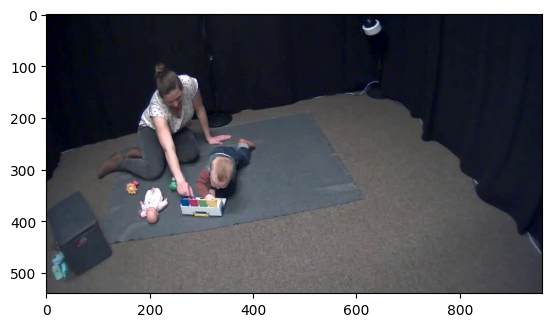

In [148]:
plt.imshow(norm_vae_frames[0])

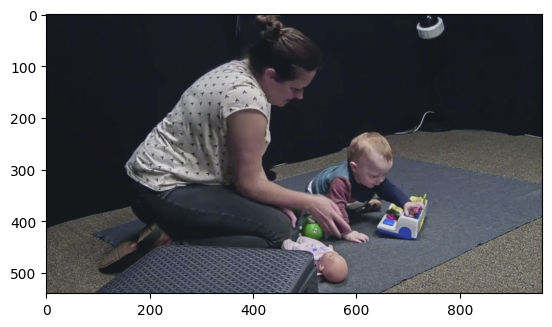

In [149]:
plt.imshow(norm_vae_frames[5])

In [40]:
image = copy.deepcopy(masks_per_view[0][0])
n_clusters = 2
data = cv2.resize(image, (100, 100)).reshape(-1, 3)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv2.KMEANS_RANDOM_CENTERS
compactness, labels, centers = cv2.kmeans(data.astype(np.float32), n_clusters, None, criteria, 10, flags)

cluster_sizes = np.bincount(labels.flatten())

palette = []
for cluster_idx in np.argsort(-cluster_sizes):
    palette.append(np.full((image.shape[0], image.shape[1], 3), fill_value=centers[cluster_idx].astype(int), dtype=np.uint8))
palette = np.hstack(palette)

sf = image.shape[1] / palette.shape[1]
out = np.vstack([image, cv2.resize(palette, (0, 0), fx=sf, fy=sf)])

In [65]:
#compactness, labels, centers

for color in centers:
    val = [i * 255 for i in color]
    print(val)

[151.9404101371765, 136.74390077590942, 85.99562510848045]
[16.60373914986849, 13.561178762465715, 5.317044714465737]


In [18]:
def calc_color_hist(image):
    image = image.astype(np.float32)
    image = image * 255

    #image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    chans = cv2.split(image)
    #h,s,v = cv2.split(image)
    #mask = (v == 0) + (v == 100) + (s == 0)
    #mask = np.logical_not(mask)


    colors = ('r', 'g', 'b')

    plt.figure()
    mask = np.zeros(image.shape[:2]).astype(np.float32)

    #print(np.shape(mask))

    hist = cv2. calcHist(chans, [0, 1, 2], None, [16, 16, 16], [1, 256, 1, 256, 1, 256])
    hist_norm = cv2.normalize(hist, hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    return hist_norm
    

In [19]:
hist_per_view = [] #[view][mask_hist]

for view in range(len(masks_per_view)):
    det_hists = []
    for det in masks_per_view[view]:
        det_hists.append(calc_color_hist(det))
    hist_per_view.append(det_hists)
    

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [165]:
def compare_hist(hist1, hist2):
    # 1: *Chi-square* -> 0 means same colors
    dist_0 = 0.5 * (cv2.compareHist(hist1, hist2, 1) / (hist1.size - 1))
    dist_1 = 0.5 * (cv2.compareHist(hist2, hist1, 1) / (hist2.size - 1))
    
    return (dist_0 + dist_1) / 2

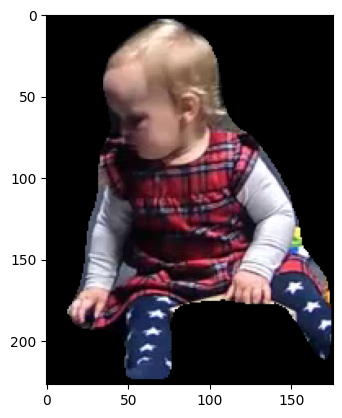

In [21]:
plt.imshow(masks_per_view[0][0])

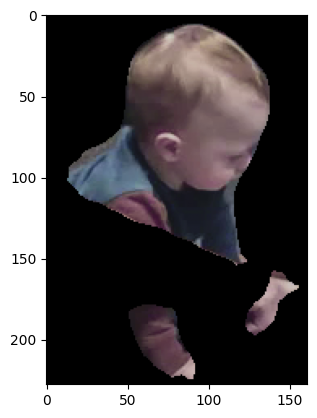

In [195]:
plt.imshow(masks_per_view[2][0])


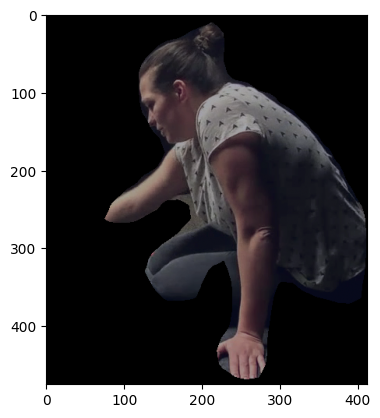

In [193]:
plt.imshow(masks_per_view[6][1])

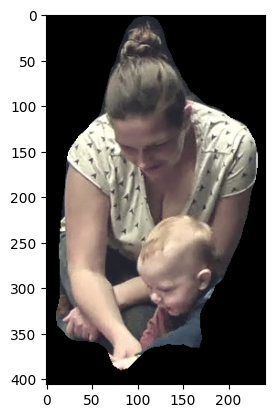

In [190]:
plt.imshow(masks_per_view[1][0])

In [196]:
# 1: *Chi-square* -> 0 means same colors
compare_hist(hist_per_view[2][0], hist_per_view[1][0])

0.016037507800691773

In [191]:
compare_hist(hist_per_view[5][1], hist_per_view[1][0])

0.024227296836185522

In [192]:
compare_hist(hist_per_view[6][1], hist_per_view[1][0])

0.010304708698047204

In [ ]:
compare_hist(hist_per_view[5][1], hist_per_view[1][0])

0.000125514294403583

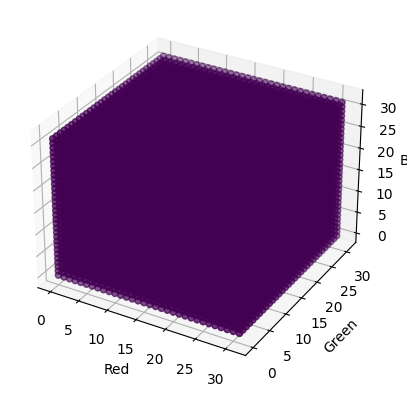

In [153]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

aaa = hist_per_view[5][0] * 255

x_bins, y_bins, z_bins = aaa.shape
x_data, y_data, z_data = np.meshgrid(range(x_bins), range(y_bins), range(z_bins))
ax.scatter(x_data.flatten(), y_data.flatten(), z_data.flatten(), c=aaa.flatten(), cmap='viridis')
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')

plt.show()

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\histogram.cpp:160: error: (-215:Assertion failed) j < nimages in function 'cv::histPrepareImages'


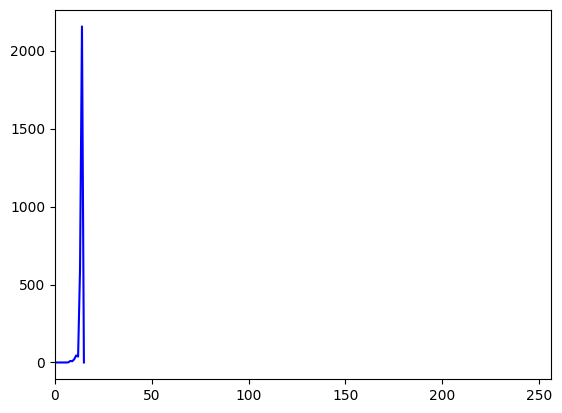

In [155]:
color = ('b','g','r')
pa = norm_vae_frames[5][0] * 255

for i,col in enumerate(color):
    histr = cv2.calcHist([pa],[i],None,[16],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

# Run on video method


In [328]:
class FrameVideoDetectionInfo:
    def __init__(self, n_classes = []):
         self._n_classes = []
      
    def get_nDetectedClasses(self):
        return self._n_classes
      
    def set_nDetectedClasses(self, x):
        self._n_classes = x

In [329]:
def getVideoInfo(name):
    video = cv2.VideoCapture(name)
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frames_per_second = video.get(cv2.CAP_PROP_FPS)
    num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f'{name} is {width} by {height}, with a total of {num_frames} frames')
    
    return video, width, height, frames_per_second, num_frames

In [101]:
def runOnVideo(video, maxFrames, vid_obj):
    """ Runs the predictor on every frame in the video (unless maxFrames is given),
    and returns the frame with the predictions drawn.
    """
    class_detected = []
    readFrames = 0
    while True:
        hasFrame, frame = video.read()
        if not hasFrame:
            break

        # Get prediction results for this frame
        outputs = predictor(frame)

        # Make sure the frame is colored
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            
        # Draw a visualization of the predictions using the video visualizer
        visualization = v.draw_instance_predictions(frame, outputs["instances"].to("cpu"))

        # Convert Matplotlib RGB format to OpenCV BGR format
        visualization = cv2.cvtColor(visualization.get_image(), cv2.COLOR_RGB2BGR)

        #print(f'Frame n. {readFrames} has {len(outputs["instances"].pred_classes)} classes detected')
        
        class_detected.append(len(outputs["instances"].pred_classes))
        yield visualization
       

        readFrames += 1
        if readFrames >= maxFrames:
            vid_obj.set_nDetectedClasses(class_detected)
            break

Standart object segmentation takes 30 seconds per 100 frames

Fine tunned model object segmentation takes 22 seconds per 100 frames

In [102]:
def processVideo(name, video, width, height, frames_per_second, num_frames, vid_obj):
    name_out = name.split('.mp4')[0]
    name_out += '_output.mp4'
    
    video_writer = cv2.VideoWriter(name_out, fourcc=cv2.VideoWriter_fourcc(*"mp4v"), 
                               fps=float(frames_per_second), frameSize=(width, height), isColor=True)
    
    # Initialize visualizer
    v = VideoVisualizer(MetadataCatalog.get('my_dataset_coco_person_640'), ColorMode.IMAGE)

    # Create a cut-off for debugging
    #num_frames = 501 

    # Enumerate the frames of the video
    for visualization in tqdm.tqdm(runOnVideo(video, num_frames, vid_obj), total=num_frames):

        # Write test image
        cv2.imwrite('detectron640.png', visualization)

        # Write to video file
        video_writer.write(visualization)

    # Release resources
    video.release()
    video_writer.release()
    print(f'Video {name} Processed!')

In [109]:
vid_obj_a1 = FrameVideoDetectionInfo()
vid_obj_a2 = FrameVideoDetectionInfo()
vid_obj_b1 = FrameVideoDetectionInfo()
vid_obj_b2 = FrameVideoDetectionInfo()

In [110]:
processVideo(name_1a, video_1a, width_1a, height_1a, frames_per_second_1a, num_frames_1a, vid_obj_a1)


100%|████████████████████████████████████████████████████████████████████████████████| 502/502 [02:05<00:00,  4.00it/s]

Video Videos\Laura_1_t1b_clip_20.mp4 Processed!


In [111]:
print(sum(vid_obj_a1.get_nDetectedClasses())/len(vid_obj_a1.get_nDetectedClasses()))

2.137450199203187
